In [1]:
import rouskinhf
import pandas as pd
import numpy as np
import os

In [27]:

training_dataset_names = ['rnacentral_synthetic', 'ribo500-blast', 'bpRNA-1m', 'pri_miRNA', 'human_mRNA', 'efold_train', 'all_training_data']
testing_dataset_names = ["PDB", "archiveII", "viral_fragments", "lncRNA_nonFiltered", 'all_testing_data']

def dataset_to_df(dataset_name):
    if dataset_name == 'all_training_data':
        return pd.concat([dataset_to_df(name) for name in training_dataset_names if name != 'all_training_data'])

    if dataset_name == 'all_testing_data':
        return pd.concat([dataset_to_df(name) for name in testing_dataset_names if name != 'all_testing_data'])
    return pd.DataFrame.from_dict(rouskinhf.get_dataset(dataset_name), orient='index').reset_index()

train_set = pd.concat({name: dataset_to_df(name) for name in training_dataset_names})
train_set = train_set.drop_duplicates('sequence')
test_set = pd.concat({name: dataset_to_df(name) for name in testing_dataset_names})

efold_train_set: Downloading dataset from HuggingFace Hub...


RepositoryNotFoundError: 404 Client Error. (Request ID: Root=1-66632bdc-2c9ff1ae582851b15b5c6ed5;1cc3ec95-bd68-4670-a8fa-ceefe3dd8fd5)

Repository Not Found for url: https://huggingface.co/api/datasets/rouskinlab/efold_train_set/revision/main.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated.

In [3]:
def write_fasta(df, filename):
    with open(filename, 'w') as f:
        for i, row in df.iterrows():
            f.write(f'>{row["index"]}\n{row["sequence"]}\n')

def create_dataset(dataset_list, name):
    data = []
    for name in dataset_list:
        data.append(dataset_to_df(name))

    data = pd.concat(data)
    os.makedirs('fasta', exist_ok=True)
    write_fasta(data, f'db/{name}.fasta')
    cmd = f'makeblastdb -in db/{name}.fasta -dbtype nucl -out db/{name}'
    os.system(cmd)
    
create_dataset(training_dataset_names, 'all_training_data')
create_dataset(testing_dataset_names, 'all_testing_data')



Building a new DB, current time: 06/07/2024 08:38:20
New DB name:   /Users/yvesmartin/src/supermodels-data/db/all_training_data
New DB title:  db/all_training_data.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /Users/yvesmartin/src/supermodels-data/db/all_training_data
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 724566 sequences in 7.51858 seconds.




Building a new DB, current time: 06/07/2024 08:38:30
New DB name:   /Users/yvesmartin/src/supermodels-data/db/all_testing_data
New DB title:  db/all_testing_data.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /Users/yvesmartin/src/supermodels-data/db/all_testing_data
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 7824 sequences in 0.0894499 seconds.




In [4]:
def write_fasta(df, filename):
    with open(filename, 'w') as f:
        for i, row in df.iterrows():
            f.write(f'>{row["index"]}\n{row["sequence"]}\n')
    

def create_dataset(name):
    data = dataset_to_df(name)
    os.makedirs('fasta', exist_ok=True)
    write_fasta(data, f'db/{name}.fasta')
    cmd = f'makeblastdb -in db/{name}.fasta -dbtype nucl -out db/{name}'
    os.system(cmd)
    
for name in training_dataset_names:
    create_dataset(name)

for name in testing_dataset_names:
    create_dataset(name)



Building a new DB, current time: 06/07/2024 08:38:40
New DB name:   /Users/yvesmartin/src/supermodels-data/db/rnacentral_synthetic
New DB title:  db/rnacentral_synthetic.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /Users/yvesmartin/src/supermodels-data/db/rnacentral_synthetic
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 226729 sequences in 2.33151 seconds.




Building a new DB, current time: 06/07/2024 08:38:49
New DB name:   /Users/yvesmartin/src/supermodels-data/db/ribo500-blast
New DB title:  db/ribo500-blast.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /Users/yvesmartin/src/supermodels-data/db/ribo500-blast
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 66285 sequences in 0.679191 seconds.




Building a new DB, current time: 06/07/2024 08:38:55
New DB name:   /Users/yvesmartin/src/supermodels-data/db/bpRNA-1m
New DB title:  db/bpRNA-1m.fas

In [5]:
def compare_fasta_to_db(train, test):
    path = '/Users/yvesmartin/src/supermodels-data/db'
    cmd = f'blastn -query {path}/{test}.fasta -db {path}/{train} -outfmt 6 -out {path}/{train}__{test}.csv'
    os.system(cmd)

for train_set in training_dataset_names:
    for test_set in testing_dataset_names:
        compare_fasta_to_db(train_set, test_set)

In [6]:
def read_blast_result(train, test):
    path = '/Users/yvesmartin/src/supermodels-data/db'
    df = pd.read_csv(f'{path}/{train}__{test}.csv', sep='\t', header=None, names=['query', 'subject', 'identity', 'length', 'mismatches', 'gapopenings', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore'])
    df.drop_duplicates('query', keep='first', inplace=True)
    return {
        'n_hits': len(df),
        'n_seq': len(rouskinhf.get_dataset(test)) if test != 'all_testing_data' else sum([len(rouskinhf.get_dataset(name)) for name in testing_dataset_names if name != 'all_testing_data']),
        'train': train,
        'test': test,
    }

results =[]
for train_set in training_dataset_names:
    for test_set in testing_dataset_names:
        results.append(read_blast_result(test=test_set,train=train_set))
        
df = pd.DataFrame(results)
df['labels'] = df['n_hits'].astype(str) + '/' + df['n_seq'].astype(str)
df['ratio'] = df['n_hits'] / df['n_seq']

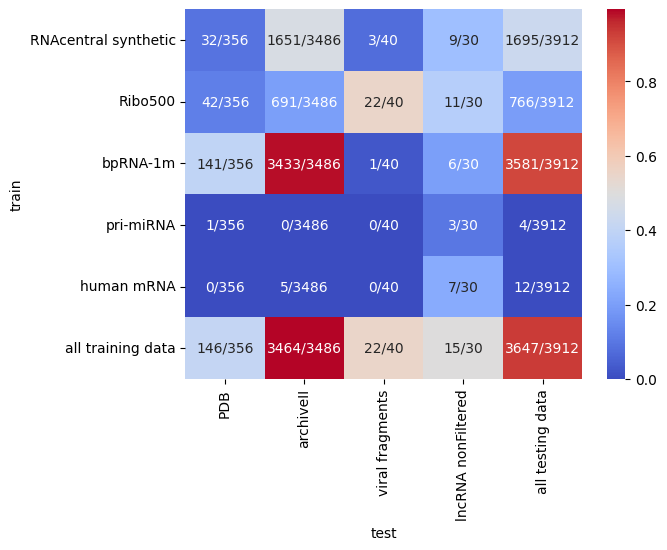

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

translation = {
    'rnacentral_synthetic': 'RNAcentral synthetic',
    'ribo500-blast': 'Ribo500',
    'bpRNA-1m': 'bpRNA-1m',
    'pri_miRNA': 'pri-miRNA',
    'human_mRNA': 'human mRNA',
    'all_training_data': 'all training data',
    'PDB': 'PDB',
    'archiveII': 'archiveII',
    'viral_fragments': 'viral fragments',
    'lncRNA_nonFiltered': 'lncRNA nonFiltered',
    'all_testing_data': 'all testing data',
}

vals = df.pivot(index='train', columns='test', values='ratio')
# column scheme should be 1 2 3 4 5 0 
vals = vals.loc[training_dataset_names, testing_dataset_names]
annot = df.pivot(index='train', columns='test', values='labels')
annot = annot.loc[training_dataset_names, testing_dataset_names]


fig = sns.heatmap(vals, annot=annot, cmap='coolwarm', fmt='s')

fig.set_xticklabels([translation[name.get_text()] for name in fig.get_xticklabels()])
fig.set_yticklabels([translation[name.get_text()] for name in fig.get_yticklabels()])

plt.show()

In [21]:
fig.get_xlabel()

'test'

In [9]:
print("{}/{} sequences of the testing set are in the training set".format(len(set(test_set['sequence']).intersection(set(train_set['sequence']))), len(test_set['sequence'])))

TypeError: string indices must be integers, not 'str'

In [ ]:
intersection = pd.merge(train_set.reset_index(), test_set.reset_index(), on='sequence', how='inner')

import plotly.express as px

intersection['source'] = intersection['level_0_x'] + ' contains ' + intersection['level_0_y']

fig = px.pie(intersection, names='source', title='Sources of the sequences in the intersection of the training and testing sets')
fig.show()

In [ ]:
train_set.index

In [ ]:
# tun blast

!mkdir -p blast

def write_fasta(filename, df):
    with open(filename, 'w') as f:
        for i, seq in enumerate(sequences):
            f.write(">{}\n{}\n".format(i, seq))
            
    
# make a blast database
!makeblastdb -in blast/train.fasta -dbtype nucl -out blast/train
